In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

## A/B Testing

Did maternal smokers result in a different baby weight?

In [23]:
baby = Table.read_table('http://inferentialthinking.com/notebooks/baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [4]:
baby.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


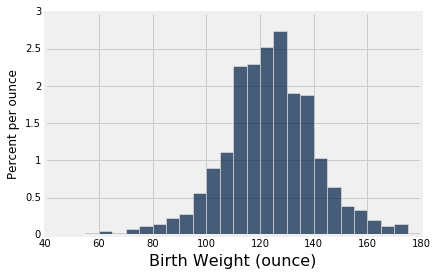

In [5]:
weight_bins = np.arange(40, 181, 5)
baby.where('Maternal Smoker', False).hist('Birth Weight', bins=weight_bins, unit='ounce')

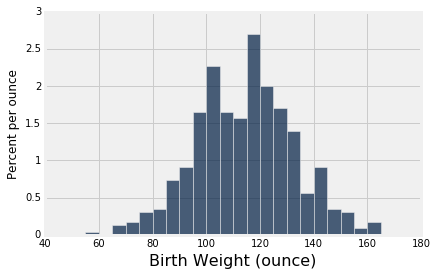

In [6]:
baby.where('Maternal Smoker', True).hist('Birth Weight', bins=weight_bins, unit='ounce')

Take a guess: Do you think there's a significant difference?

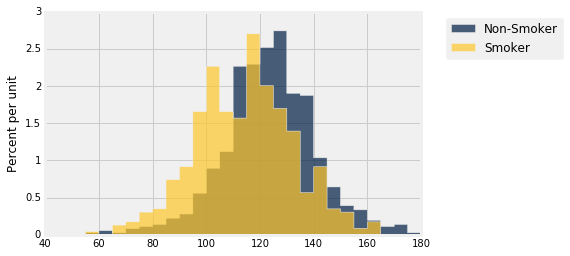

In [7]:
baby.where('Maternal Smoker', False).bin('Birth Weight', bins=weight_bins).join(
    'bin', baby.where('Maternal Smoker', True).bin('Birth Weight', bins=weight_bins)
).relabeled(1, 'Non-Smoker').relabeled(2, 'Smoker').hist(bin_column='bin')

In [8]:
smoke_weight = baby.select('Maternal Smoker', 'Birth Weight')
means = smoke_weight.group(0, np.mean)
means

Maternal Smoker,Birth Weight mean
False,123.085
True,113.819


In [9]:
def difference_in_means(t):
    means = t.group(0, np.mean)
    return means.column(1).item(0) - means.column(1).item(1)

difference_in_means(smoke_weight)

9.266142572024918

In [10]:
def permutation_test_means(table, variable, classes, repetitions, unit=None):
    """Test whether two numerical samples 
    come from the same underlying distribution, 
    using the absolute difference between the means.
    table: name of table containing the sample
    variable: label of column containing the numerical variable 
    classes: label of column containing names of the two samples
    repetitions: number of random permutations
    
    variable -- Label for a numerical variable in table
    classes -- Label for a two-category (A & B) variable in table
    """
    
    t = table.select(classes, variable)
    observed = abs(difference_in_means(t))
    
    # Assuming the null is true, randomly permute the variable 
    # and collect all the generated test statistics
    stats = make_array()
    for i in np.arange(repetitions):
        shuffled_var = t.select(variable).sample(with_replacement=False).column(0)
        shuffled = t.select(classes).with_column('Shuffled Variable', shuffled_var)
        new_stat = abs(difference_in_means(shuffled))
        stats = np.append(stats, new_stat)
    
    # Find the empirical P-value:
    p = np.count_nonzero(stats >= observed) / repetitions

    # Draw the empirical histogram of the tvd's generated under the null, 
    # and compare with the value observed in the original sample
    Table().with_column('Test Statistic', stats).hist(unit=unit)
    plt.title('Empirical Distribution Under the Null')
    print('Observed statistic:', observed)
    print('Empirical P-value:', p)

Observed statistic: 9.266142572024918
Empirical P-value: 0.0


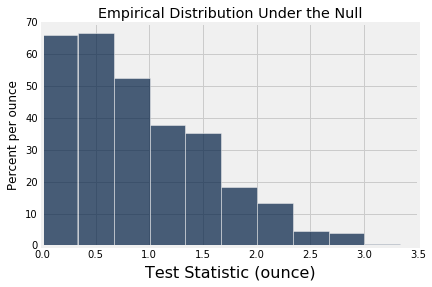

In [11]:
permutation_test_means(baby, 'Birth Weight', 'Maternal Smoker', 1000, 'ounce')

Discussion question: What can we now conclude?

## Effect Size

In [12]:
def bootstrap_ci_means(table, variable, classes, repetitions, unit=None):
    """Bootstrap approximate 95% confidence interval
    for the difference between the means of the two classes
    in the population
    """
    
    t = table.select(classes, variable)
    
    stats = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        new_stat = difference_in_means(bootstrap_sample)
        stats = np.append(stats, new_stat)
        
    left = percentile(2.5, stats)
    right = percentile(97.5, stats)
    
    Table().with_column('Difference Between Means', stats).hist(unit=unit)
    plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8)
    print('Approximate 95% CI for the difference between means:')
    print(left, 'to', right)

Approximate 95% CI for the difference between means:
7.09502194115 to 11.3643545192


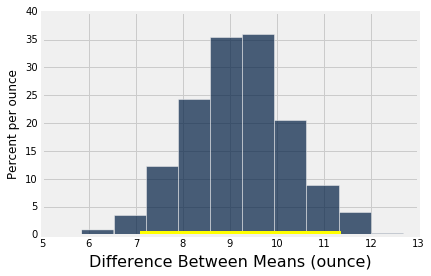

In [13]:
bootstrap_ci_means(baby, 'Birth Weight', 'Maternal Smoker', 1000, 'ounce')

For these, use permutation_test first.

Approximate 95% CI for the difference between means:
0.174015830503 to 1.46873916274


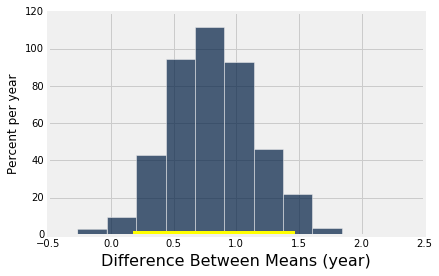

In [14]:
bootstrap_ci_means(baby, 'Maternal Age', 'Maternal Smoker', 1000, 'year')

Approximate 95% CI for the difference between means:
-0.406538630699 to 0.218879495118


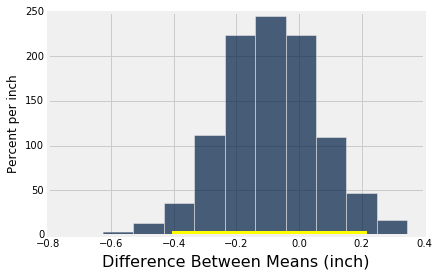

In [15]:
bootstrap_ci_means(baby, 'Maternal Height', 'Maternal Smoker', 1000, 'inch')

## RCTs

In [24]:
bta = Table.read_table('http://inferentialthinking.com/notebooks/bta.csv')
bta.show(3)

Group,Result
Control,1
Control,1
Control,0


In [18]:
bta.group('Group', np.mean)

Group,Result mean
Control,0.125
Treatment,0.6


Observed statistic: 0.475
Empirical P-value: 0.009


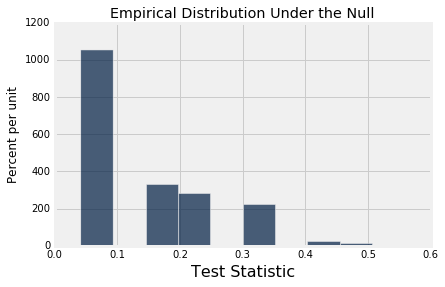

In [19]:
permutation_test_means(bta, 'Result', 'Group', 1000)

What does this interval mean?

Approximate 95% CI for the difference between means:
-0.777777777778 to -0.170833333333


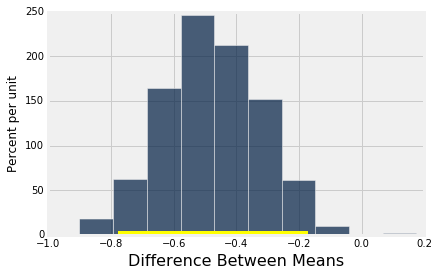

In [20]:
bootstrap_ci_means(bta, 'Result', 'Group', 1000)